In [1]:
import sys
import os
sys.path.append("..")
import torch
from tqdm.notebook import tqdm

In [2]:
from mango.environments import frozen_lake
from mango.actions import grid2d
from mango.policies import DQNetPolicy
from mango.saving import save_to_file
from mango.utils.plotting import plot_loss_reward
from mango import Mango

In [7]:
# parameters of the environment
env_params = {
    "map_name": "8x8",
    "shape": (8, 8),
    "p": 0.5,
    "goal_pos": [(0, 0), (-1, 0), (-1, -1), (0, -1)],
    "start_pos": [(0, 0), (-1, 0), (-1, -1), (0, -1)],
}

# parameters of abstract actions
cell_shapes = [(2, 2), (4, 4)]
gamma = 0.8
lr = 1e-3
net_params = dict(
    hidden_channels=[4, 4],
    hidden_features=[],
    activation_out=torch.nn.Tanh(),
    # device=torch.device("cuda") if torch.cuda.is_available() else None,
)

# parameters of the training
N_episodes = 1000
episode_length = 10
train_steps = 5

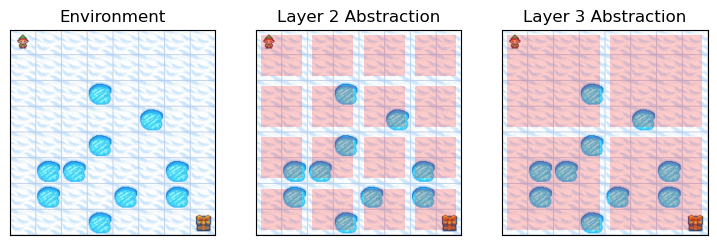

In [8]:
env = frozen_lake.CustomFrozenLakeEnv(**env_params)
env = frozen_lake.wrappers.ReInitOnReset(env, **env_params)
env = frozen_lake.wrappers.TensorObservation(env, one_hot=True)
env_shape = env.unwrapped.nrow, env.unwrapped.ncol

option_manager = Mango(
    environment=env,  # type: ignore
    abstract_actions=[
        grid2d.SubGridMovement(
            cell_shape=cell_shape,
            grid_shape=env_shape,
            agent_channel=0,
            invalid_channel=1,
            reward=(1 - gamma),
        )
        for cell_shape in cell_shapes
    ],
    dynamic_policy_params=dict(
        policy_cls=DQNetPolicy,
        policy_params=dict(lr=lr, gamma=gamma, net_params=net_params),
    ),
)
option_manager.reset()
frozen_lake.plot_utils.plot_all_abstractions(option_manager)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

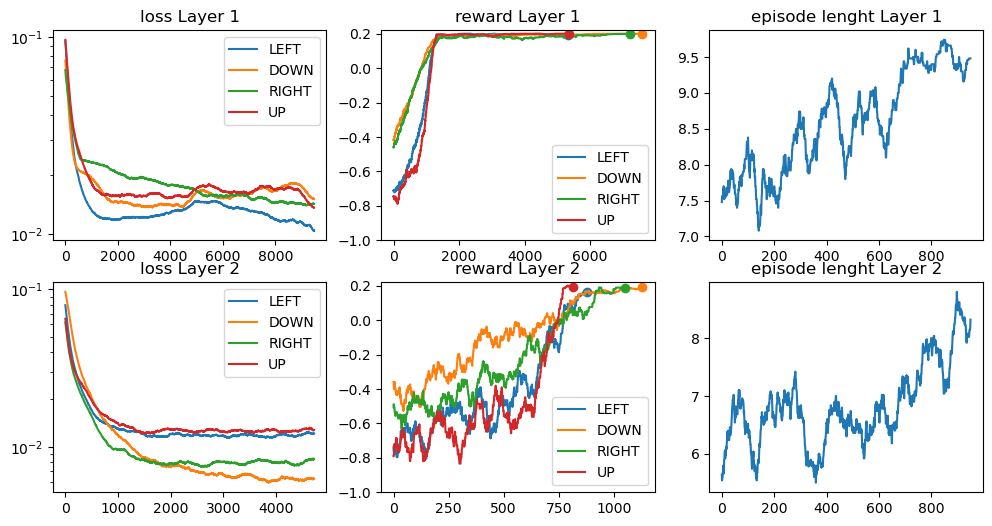

In [5]:
randomness = [((N_episodes - 1 - i) / N_episodes) for i in range(N_episodes)]
for layer in [1, 2]:
    for r in (pbar := tqdm(randomness)):
        pbar.set_description(f"randomness: {r:.3f}")
        option_manager.set_randomness(r, layer=layer)
        obs, reward, term, trunc, info = option_manager.explore(layer, episode_length)
        for _ in range(train_steps):
            option_manager.train()
plot_loss_reward(option_manager, grid2d.Actions, reward_lims=(-1, 1.1 * (1 - gamma)))

dir_path = frozen_lake.utils.path_to_save_dir(env_params)
os.makedirs(dir_path, exist_ok=True)
save_to_file(path=dir_path + "option_manager.pickle", obj=option_manager)

LEFT
DOWN
RIGHT
UP


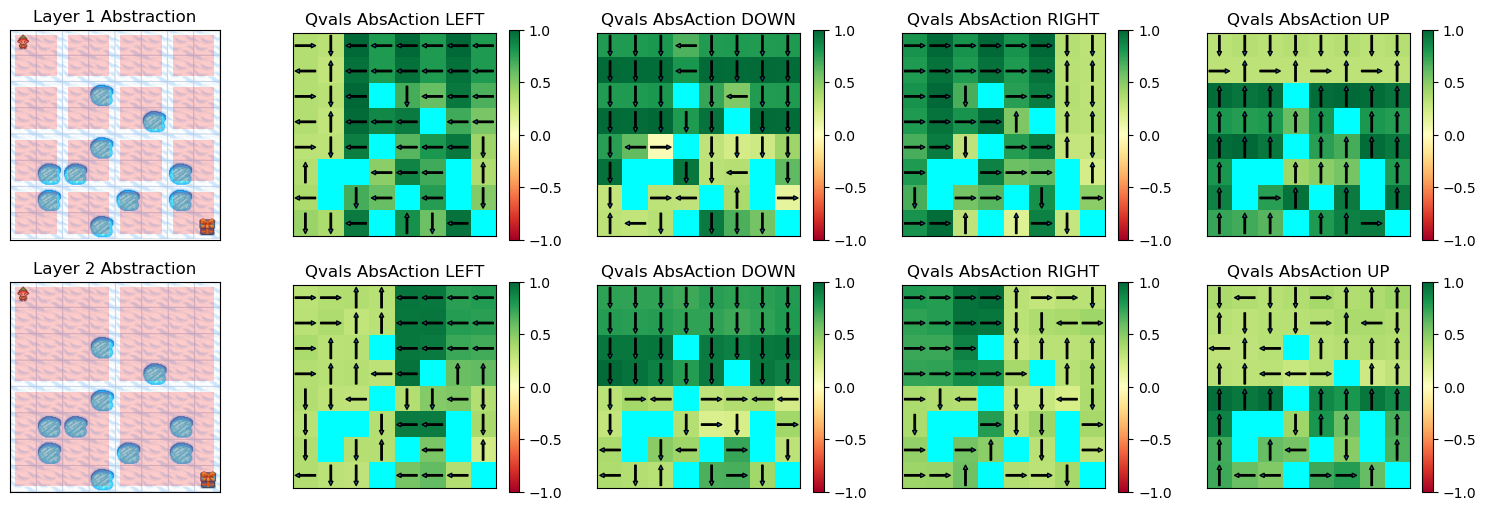

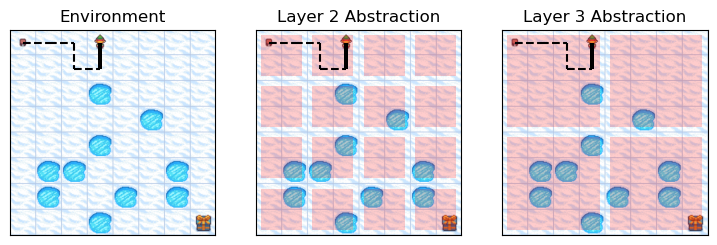

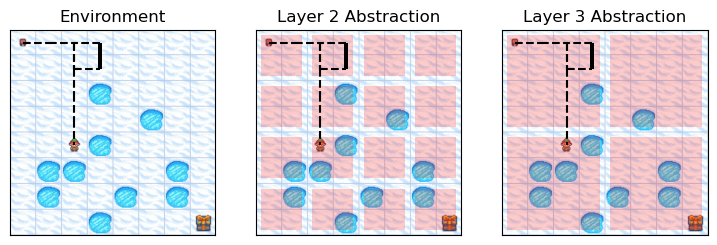

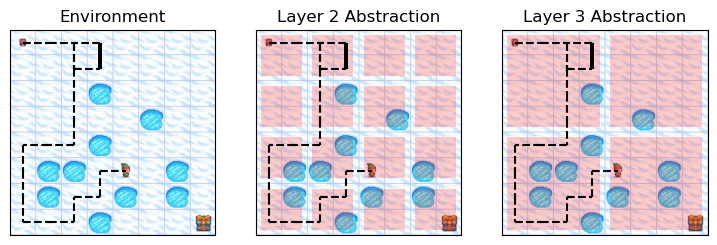

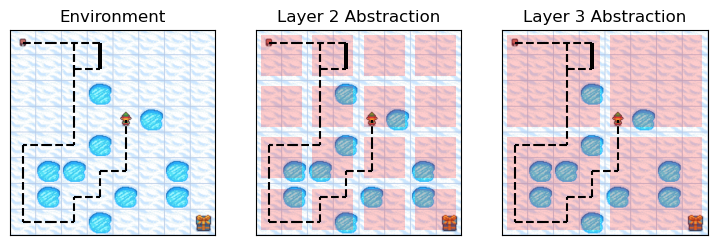

In [6]:
obs, info = option_manager.reset()
frozen_lake.plot_utils.plot_all_qvals(option_manager)
trajectory = [obs]
for action in grid2d.Actions:
    print(action.name)
    for step in range(10):
        obs, reward, trunc, term, info = option_manager.step((-1, action.value))
        trajectory.extend(info["mango:trajectory"])
        if not info["mango:truncated"]:
            break
    frozen_lake.plot_utils.plot_all_abstractions(option_manager, trajectory)